In [1]:
import pandas as pd
import re
import numpy as np

from utils import database as db
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
_data = pd.read_csv('pbp_matches_itf_main_archive.csv')
_ref = pd.read_csv("Wimbledon_featured_matches.csv")

In [3]:
data = _data.copy()
ref = _ref.copy().iloc[5:7]
data.head()

,pbp_id,date,tny_name,tour,draw,server1,server2,winner,pbp,score,adf_flag,wh_minutes
0,2233688,28 Jul 11,ITFTour-PresidentsCup,ITF,Main,Denys Molchanov,Mikhail Kukushkin,2,SSSS;RRRR;SSSS;RSSSS;RRRR;SSSS;RRRR;SSSS;SSSS;...,6-7(0) 6-4 6-3,0,39
1,2233689,28 Jul 11,ITFTour-PresidentsCup,ITF,Main,Marco Chiudinelli,Nikoloz Basilashvili,1,SSSS;SRRSRR;SRRRSSRSRSSS;RSSSS;SSRSRS;SRRRSR;S...,6-1 6-1,0,49
2,2234612,28 Jul 11,ITFTour-Vigo,ITF,Main,Miharu Imanishi,Leticia Costas-Moreira,2,RRSSSS;RRRSR;SRRRR;SRSSRS;SRSRRR;SSSRRS;RSRRR;...,6-3 6-3,0,94
3,2234613,28 Jul 11,ITFTour-Vigo,ITF,Main,Marianna Zakarlyuk,Iryna Bremond,2,RSRRR;SSSRRS;SSSRS;SSSS;SSRRSRRSSS;SRRSRR;RRSR...,6-4 6-4,0,76
4,2262305,08 Aug 11,ITFTour-Koksijde,ITF,Main,Valerie Verhamme,Garbine Muguruza Blanco,2,SSSS;RRRSSSSS;RRRR;SSSS;RRRSSSRR;SSSS;RRSSRR.S...,6-1 6-2,0,55


In [4]:
ref

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
5,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:50,1,1,6,0,0,0,...,0,0,0,5.291,4.249,2,97.0,BW,NCTL,ND
6,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:03:33,1,1,7,0,0,0,...,0,0,0,6.817,17.821,1,109.0,W,CTL,D


In [5]:
match = data.iloc[52]
match

pbp_id                                                  2252139
date                                                  04 Aug 11
tny_name                                         ITFTour-Vienna
tour                                                        ITF
draw                                                       Main
server1                                            Simona Dobra
server2                                     Lucie Kriegsmannova
winner                                                        1
pbp           SSSRRS;RSRSRR;RSRSSRRR;SRRRR;SRRSSS;SSSS;RRRR;...
score                                            5-7 7-6(2) 6-4
adf_flag                                                      0
wh_minutes                                                  170
Name: 52, dtype: object

In [6]:
p1 = match['server1']
p2 = match['server2']

count = match['pbp'].count('R')+match['pbp'].count('S')
gcount = match['pbp'].count(';')

aver_t = match['wh_minutes']/count
a = int(count/3)
print(count, gcount, aver_t)

236 32 0.7203389830508474


In [7]:
inputs = {
    'p2': ['p2_win', 'p1_win','p1_game_win','p2_game_win', 'p2_score_diff', 'p2_ser'],
    'p1': ['p1_win', 'p2_win','p1_game_win','p2_game_win', 'p1_score_diff', 'p1_ser'],
    'gen':[]
}

In [8]:
columns = [
        'player1',
        'player2',

        'elapsed_time',
        
        'p1_win', 
        'p2_win',
        'p1_distance_run',
        "p2_distance_run",
        'p1_game_win',
        'p2_game_win', 
        'p1_score_diff', 
        'p2_score_diff', 
        'p1_unf_err', 
        'p2_unf_err', 
        "p1_ser_sp", 
        'p1_ser',
        "p2_ser_sp", 
        'p2_ser'
        
]

In [9]:
point1=0
point2=0

data = pd.DataFrame(columns = columns)
i = 0
for _, p in enumerate(match['pbp']):
    firs = i%2==1
    if (p == 'R' and firs) or (p == 'S' and not firs): # not player 1 lose
        p1w=False
        p2w=True
        p1g=False
        p2g=False

        point2+=1
        i+=1
    elif (p == 'S' and firs) or (p == 'R' and not firs):
        p1w=True
        p2w=False
        p1g=False
        p2g=False

        point1+=1
        i+=1
    elif p == ';':
        if point1 > point2:
            p1g=p1w=True
            p2g=p2w=False
        else:
            p1g=p1w=False
            p2g=p2w=True
            
        point1=point2=0

    elap = i*aver_t
    elap = pd.to_datetime(elap,unit='m').round('1s')
    
    r = {
        'player1':p1,
        'player2':p2,

        'elapsed_time' : elap,
        
        'p1_win':p1w, 
        'p2_win':p2w,
        'p1_distance_run':0,
        "p2_distance_run":0,
        'p1_game_win':p1g,
        'p2_game_win':p2g, 
        'p1_score_diff':point1-point2, 
        'p2_score_diff':point2-point1, 
        'p1_unf_err':0, 
        'p2_unf_err':0, 
        "p1_ser_sp":0, 
        'p1_ser':firs,
        "p2_ser_sp":0, 
        'p2_ser':not firs
        
    }

    data.loc[i]=r
    #print(r)
    

In [10]:
data = data.set_index("elapsed_time")
data

,player1,player2,p1_win,p2_win,p1_distance_run,p2_distance_run,p1_game_win,p2_game_win,p1_score_diff,p2_score_diff,p1_unf_err,p2_unf_err,p1_ser_sp,p1_ser,p2_ser_sp,p2_ser
elapsed_time,,,,,,,,,,,,,,,,
1970-01-01 00:00:43,Simona Dobra,Lucie Kriegsmannova,False,True,0,0,False,False,-1,1,0,0,0,False,0,True
1970-01-01 00:01:26,Simona Dobra,Lucie Kriegsmannova,True,False,0,0,False,False,0,0,0,0,0,True,0,False
1970-01-01 00:02:10,Simona Dobra,Lucie Kriegsmannova,False,True,0,0,False,False,-1,1,0,0,0,False,0,True
1970-01-01 00:02:53,Simona Dobra,Lucie Kriegsmannova,False,True,0,0,False,False,-2,2,0,0,0,True,0,False
1970-01-01 00:03:36,Simona Dobra,Lucie Kriegsmannova,True,False,0,0,False,False,-1,1,0,0,0,False,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 02:47:07,Simona Dobra,Lucie Kriegsmannova,True,False,0,0,False,False,1,-1,0,0,0,True,0,False
1970-01-01 02:47:50,Simona Dobra,Lucie Kriegsmannova,False,True,0,0,False,False,0,0,0,0,0,False,0,True
1970-01-01 02:48:34,Simona Dobra,Lucie Kriegsmannova,True,False,0,0,False,False,1,-1,0,0,0,True,0,False


In [11]:
p1_gwin_time = data[data['p1_game_win']].index
p2_gwin_time = data[data['p2_game_win']].index
p1_gwin_time

DatetimeIndex(['1970-01-01 00:08:39', '1970-01-01 00:14:24',
               '1970-01-01 00:40:20', '1970-01-01 00:59:04',
               '1970-01-01 01:19:14', '1970-01-01 01:22:50',
               '1970-01-01 01:42:17', '1970-01-01 01:50:13',
               '1970-01-01 02:00:18', '1970-01-01 02:06:04',
               '1970-01-01 02:11:49'],
              dtype='datetime64[ns]', name='elapsed_time', freq=None)

In [12]:
I1, I2 = data["p1_win"].mean(), data['p2_win'].mean()
print(I1, I2)

0.4703389830508475 0.5296610169491526


In [13]:
data_f = data.copy()

In [14]:
filter = ["p1_win","p2_win","p1_game_win","p2_game_win"]

for tar in filter:
    tar_ser = data_f[tar]

    theta = 0.2
    tar_ser = db.expected_P(tar_ser, theta, 30)
    data_f[tar] = tar_ser.values

data_f[filter]

,p1_win,p2_win,p1_game_win,p2_game_win
elapsed_time,,,,
1970-01-01 00:00:43,0.000000,1.000000,0.0,0.000000
1970-01-01 00:01:26,0.200000,0.800000,0.0,0.000000
1970-01-01 00:02:10,0.160000,0.840000,0.0,0.000000
1970-01-01 00:02:53,0.128000,0.872000,0.0,0.000000
1970-01-01 00:03:36,0.302400,0.697600,0.0,0.000000
...,...,...,...,...
1970-01-01 02:47:07,0.341918,0.658082,0.0,0.182864
1970-01-01 02:47:50,0.273535,0.726465,0.0,0.146291
1970-01-01 02:48:34,0.418828,0.581172,0.0,0.117033


In [15]:
diff = ["p1_score_diff","p2_score_diff"]

data_f[diff] = data_f[diff]/data_f[diff].std()/2
data_f[diff]

,p1_score_diff,p2_score_diff
elapsed_time,,
1970-01-01 00:00:43,-0.20186,0.20186
1970-01-01 00:01:26,0.00000,0.00000
1970-01-01 00:02:10,-0.20186,0.20186
1970-01-01 00:02:53,-0.40372,0.40372
1970-01-01 00:03:36,-0.20186,0.20186
...,...,...
1970-01-01 02:47:07,0.20186,-0.20186
1970-01-01 02:47:50,0.00000,0.00000
1970-01-01 02:48:34,0.20186,-0.20186


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import visualize as vs
sns.set_style("darkgrid")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


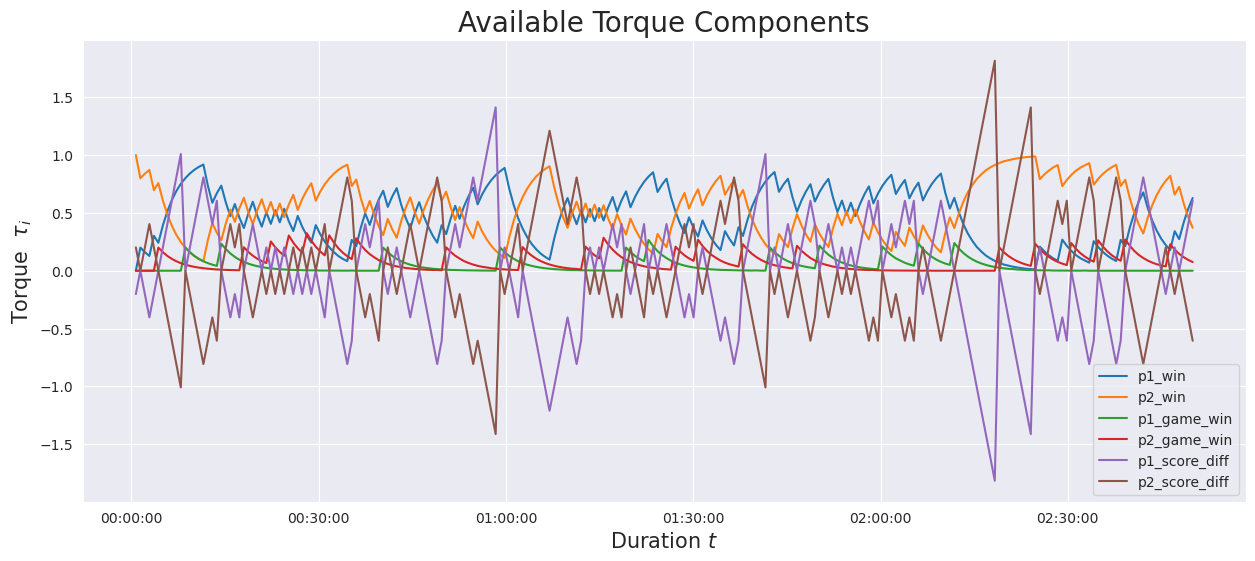

In [17]:
plt.figure(figsize=(15, 6))

plt.plot(data_f[filter+diff], label = filter+diff)
plt.legend()
vs.set_label(r"Available Torque Components", r"Duration $t$", r"Torque  $\tau_i$")
vs.set_xaxis()
vs.save("6-1-AllComps")

# Modeling

In [18]:
w1, w2 = db.get_velocity(1-data_f['p2_win'], I1, I2)
L1, L2 = I1*w1, I2*w2
DL1, DL2 = L1.diff().fillna(0), L2.diff().fillna(0)
Dt = DL1.index.diff().fillna(pd.to_timedelta("00:01:00"))
#Dt = db.to_minute(Dt)
Dt = Dt.to_series().apply(lambda x: x.total_seconds() / 60).values

T1, T2 = DL1/Dt, DL2/Dt

In [19]:
x_torque1 = data_f[inputs['p1']].values
y_torque1 = T1.values

x_torque2 = data_f[inputs['p2']].values
y_torque2 = T2.values

In [20]:
r

{'player1': 'Simona Dobra',
 'player2': 'Lucie Kriegsmannova',
 'elapsed_time': Timestamp('1970-01-01 02:50:00'),
 'p1_win': True,
 'p2_win': False,
 'p1_distance_run': 0,
 'p2_distance_run': 0,
 'p1_game_win': False,
 'p2_game_win': False,
 'p1_score_diff': 3,
 'p2_score_diff': -3,
 'p1_unf_err': 0,
 'p2_unf_err': 0,
 'p1_ser_sp': 0,
 'p1_ser': True,
 'p2_ser_sp': 0,
 'p2_ser': False}

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

model1 = LinearRegression(fit_intercept=False)
model1.fit(x_torque1[:a], y_torque1[:a])
predictions1 = model1.predict(x_torque1)

model2 = LinearRegression(fit_intercept=False)
model2.fit(x_torque2[:a], y_torque2[:a])
predictions2 = model2.predict(x_torque2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


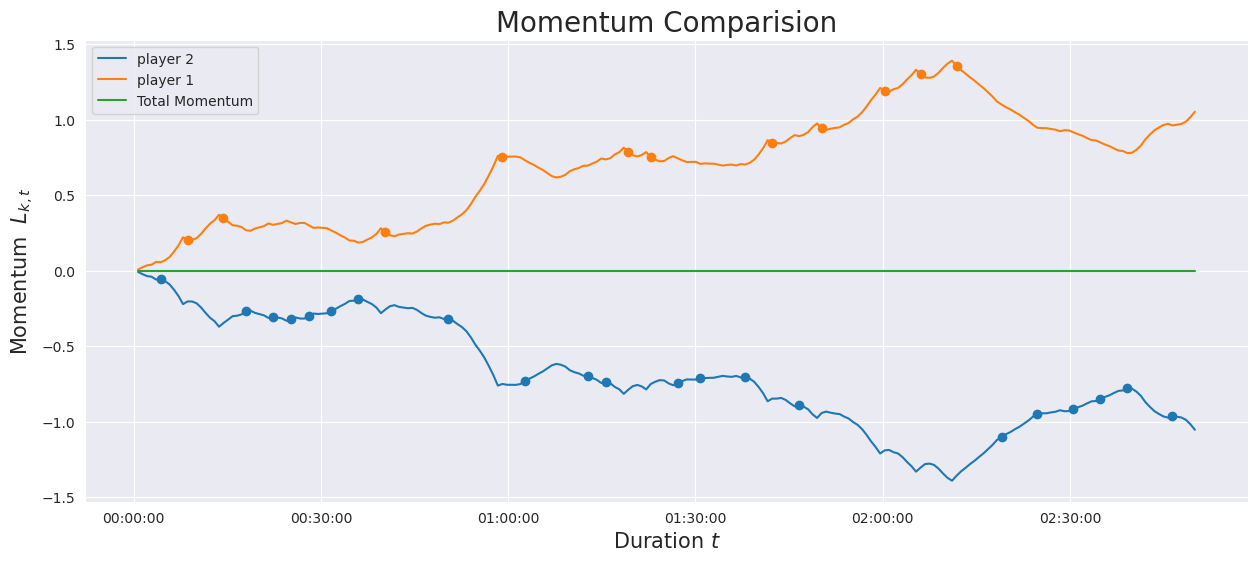

In [22]:


#eg1[tar].plot()
L1c = np.cumsum(predictions1 * Dt)
L2c = np.cumsum(predictions2 * Dt)

compare = pd.DataFrame(L1)
compare["constructed momentum"] = L1c
compare["constructed momentum2"] = L2c
compare["mean"] = L1c+L2c

plt.figure(figsize=(15, 6))
#plt.plot(compare["p1_win"], label="calculated mumentum")
plt.plot(compare["constructed momentum2"], label="player 2")
plt.plot(compare["constructed momentum"], label="player 1")
plt.plot(compare["mean"], label="Total Momentum")

plt.scatter(x=p2_gwin_time, y=compare["constructed momentum2"][p2_gwin_time])
plt.scatter(x=p1_gwin_time, y=compare["constructed momentum"][p1_gwin_time])

plt.legend()
vs.set_label(r"Momentum Comparision", r"Duration $t$", r"Momentum  $L_{k,t}$")
vs.set_xaxis()
vs.save("6-1-WPerformanceComparison")
plt.show()

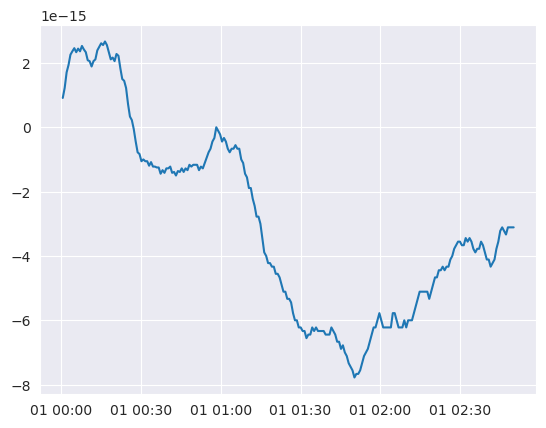

In [23]:
plt.plot(compare["mean"], label="Total Momentum")

[]

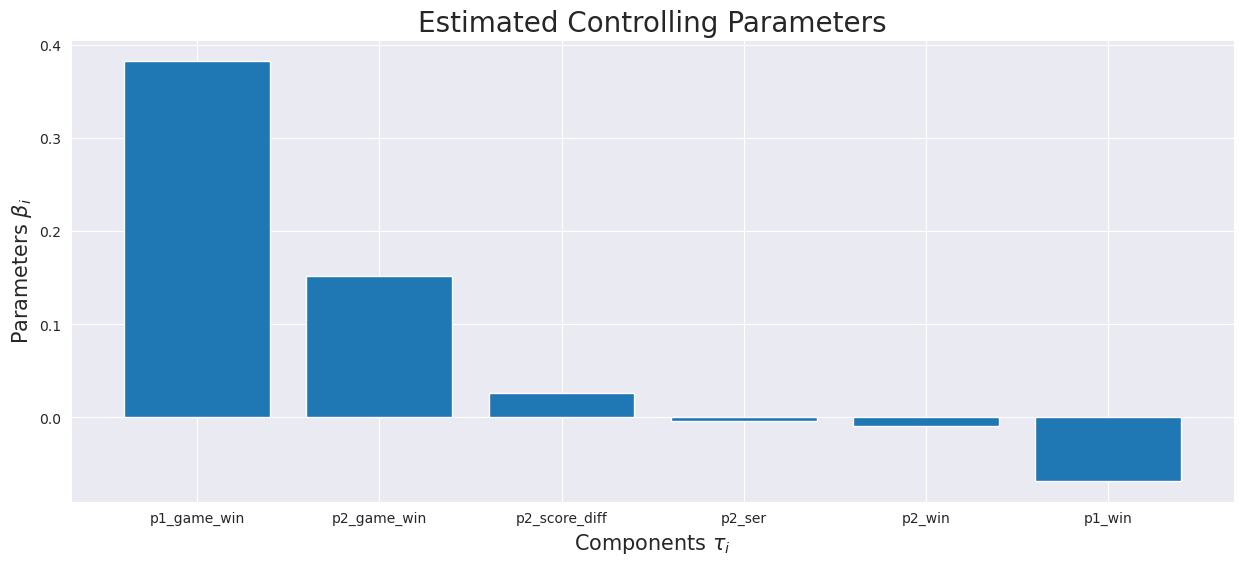

In [24]:
result2 = pd.DataFrame([inputs['p2'],model2.coef_]).T.set_index(0)
result2 = result2.sort_values(by=1, ascending=False)

plt.figure(figsize=(15, 6))
plt.bar(result2.index, result2[1])

vs.set_label(r"Estimated Controlling Parameters", r"Components $\tau_i$", r"Parameters $\beta_i$")
vs.save("6-1-LR-Result2")

plt.plot()

[]

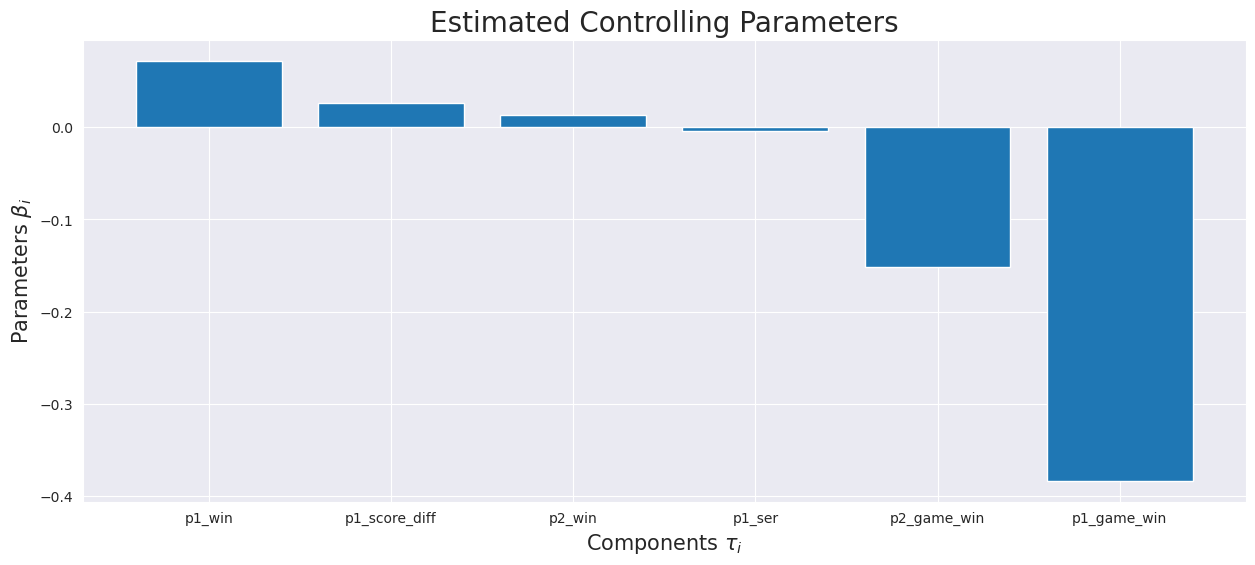

In [25]:
result1 = pd.DataFrame([inputs['p1'],model1.coef_]).T.set_index(0)
result1 = result1.sort_values(by=1, ascending=False)

plt.figure(figsize=(15, 6))
plt.bar(result1.index, result1[1])

vs.set_label(r"Estimated Controlling Parameters", r"Components $\tau_i$", r"Parameters $\beta_i$")
vs.save("6-1-LR-Result")

plt.plot()

<AxesSubplot: xlabel='elapsed_time'>

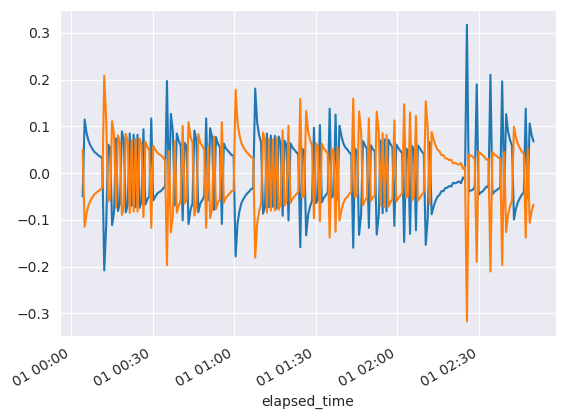

In [26]:
T1[5:].plot()
T2[5:].plot()

<AxesSubplot: xlabel='elapsed_time'>

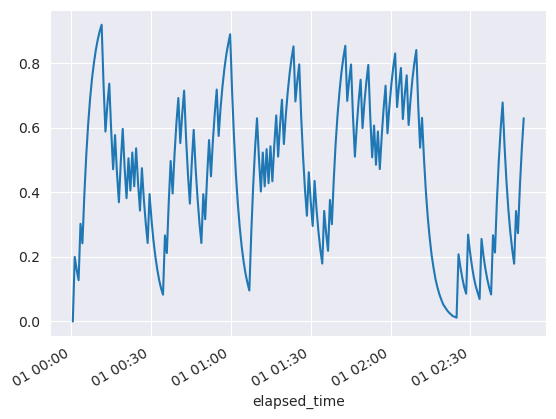

In [27]:
data_f['p1_win'].plot()

In [28]:
(predictions1 * Dt)

array([ 7.96317041e-03,  1.48680467e-02,  1.27309796e-02,  4.24773405e-03,
        1.84355225e-02, -2.02140091e-03,  1.27870763e-02,  2.18176039e-02,
        3.55272973e-02,  4.17602124e-02,  5.29993236e-02, -1.77822660e-02,
        2.11082758e-04,  1.19893013e-02,  2.76646552e-02,  3.62949848e-02,
        3.19591598e-02,  2.28976296e-02,  3.63913179e-02, -2.45927703e-02,
       -2.20703053e-02, -2.29605432e-02, -3.33109937e-03, -8.37045676e-03,
       -2.15300478e-02, -3.32942444e-03,  1.46507049e-02,  8.29189589e-03,
        7.93968827e-03,  1.78181745e-02, -9.46932009e-03,  5.87559511e-03,
        6.00664765e-03,  1.59188907e-02, -1.11569150e-02, -1.10411323e-02,
        6.96339915e-03,  6.24111797e-04, -1.72735330e-02, -1.60096766e-02,
        2.64864437e-03, -2.48777275e-03, -2.20198613e-03, -1.58558899e-02,
       -1.42909143e-02, -1.71904159e-02, -1.47230704e-02, -1.93905604e-02,
       -1.98041623e-03, -1.19945818e-02,  4.51791619e-03,  1.54868753e-02,
        1.47374770e-02,  

# Another Dataset

In [29]:
from utils import train as tr

In [30]:
_data = pd.read_excel("2023-wimbledon-fm.xlsx")

In [31]:
data = _data.copy()
data.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,ServeWidth,ServeDepth,ReturnDepth
0,2023-wimbledon-2601,Elina Svitolina,Marketa Vondrousova,00:00:00,1,1,1,0,0,0,...,0,0,0,12.337,12.005,3,81,BW,NCTL,ND
1,2023-wimbledon-2601,Elina Svitolina,Marketa Vondrousova,00:00:37,1,1,2,0,0,0,...,0,0,0,38.013,45.287,11,100,C,NCTL,ND
2,2023-wimbledon-2601,Elina Svitolina,Marketa Vondrousova,00:01:14,1,1,3,0,0,0,...,0,0,0,19.604,13.458,4,107,C,NCTL,ND
3,2023-wimbledon-2601,Elina Svitolina,Marketa Vondrousova,00:01:44,1,1,4,0,0,0,...,0,0,0,24.212,25.312,5,104,W,NCTL,ND
4,2023-wimbledon-2601,Elina Svitolina,Marketa Vondrousova,00:02:13,1,1,5,0,0,0,...,0,0,0,2.532,3.263,1,95,W,CTL,ND


In [32]:
win_lose = data.copy()
win_lose["p1_score"][win_lose["p1_score"]=='AD'] = 60
win_lose["p2_score"][win_lose["p2_score"]=='AD'] = 60
win_lose["p1_score"].iloc[:10]


win_lose = win_lose[["player1", "player2", "p1_score", "p2_score"]]
win_lose["p1_win"] = win_lose["p1_score"].astype(int)!=win_lose["p1_score"].astype(int).shift(1).fillna(0)
win_lose["p2_win"] = win_lose["p2_score"].astype(int)!=win_lose["p2_score"].astype(int).shift(1).fillna(0)
win_lose

,player1,player2,p1_score,p2_score,p1_win,p2_win
0,Elina Svitolina,Marketa Vondrousova,0,0,False,False
1,Elina Svitolina,Marketa Vondrousova,15,0,True,False
2,Elina Svitolina,Marketa Vondrousova,30,0,True,False
3,Elina Svitolina,Marketa Vondrousova,30,15,False,True
4,Elina Svitolina,Marketa Vondrousova,40,15,True,False
...,...,...,...,...,...,...
456,Marketa Vondrousova,Ons Jabeur,0,0,True,True
457,Marketa Vondrousova,Ons Jabeur,15,0,True,False
458,Marketa Vondrousova,Ons Jabeur,30,0,True,False
459,Marketa Vondrousova,Ons Jabeur,40,0,True,False


In [33]:
p1 = win_lose[["player1",'p1_win']].groupby("player1").mean()
p2 = win_lose[["player2",'p2_win']].groupby("player2").mean()
p1

,p1_win
player1,
Elina Svitolina,0.459016
Marketa Vondrousova,0.560000
Ons Jabeur,0.532710


In [34]:
players = data["player1"]
players = players._append(data["player2"], ignore_index=True).drop_duplicates().reset_index().set_index(0)
players["Inertia"] = 0
players = players.drop("index", axis = 1)

for player in players.index:
    
    if player in data["player1"].values:
        players['Inertia'][player] = p1['p1_win'][player]
    else:
        players['Inertia'][player] = p2['p2_win'][player]

players

,Inertia
0,
Elina Svitolina,0.459016
Ons Jabeur,0.532710
Marketa Vondrousova,0.560000
Aryna Sabalenka,0.579439


/home/yz812/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


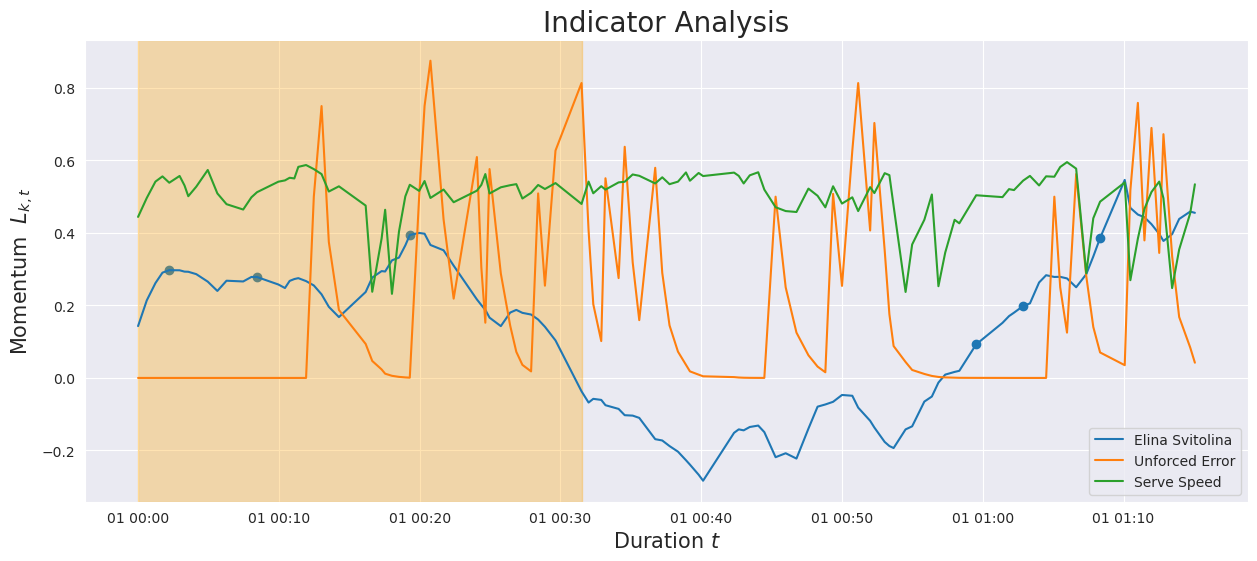

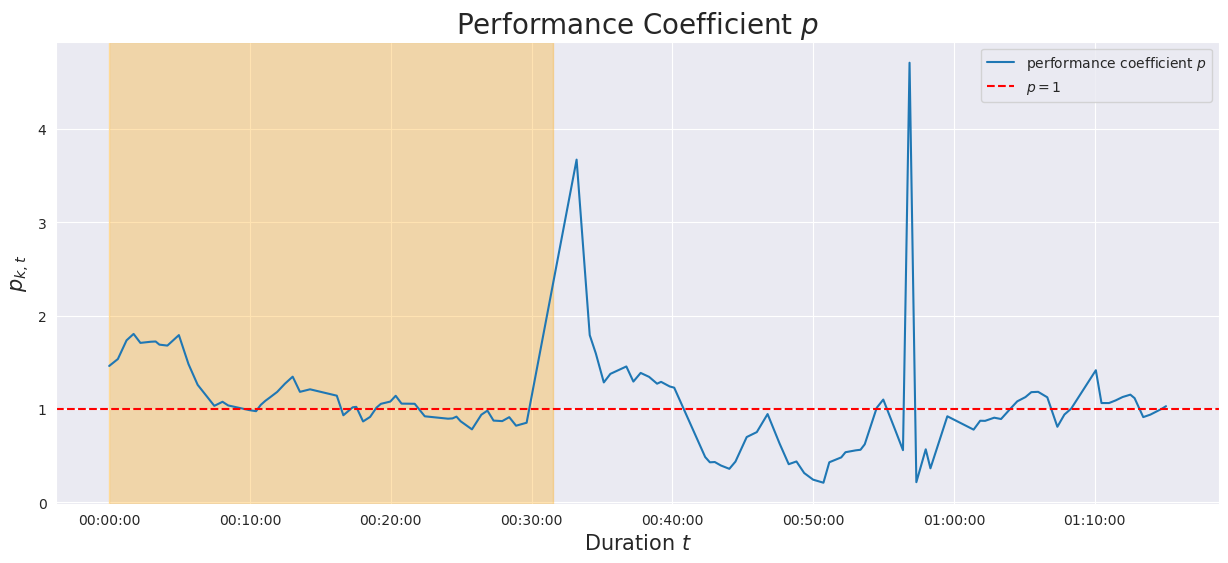

In [35]:
inputs = {
    'p1': ['p1_win', "p1_distance_run",  'p1_game_win','p2_game_win', 'p1_score_diff', 'p1_unf_err', 'p2_unf_err', "p1_ser_sp", 'p1_ser'],
    'p2': ['p2_win', "p2_distance_run",  'p1_game_win','p2_game_win', 'p1_score_diff', 'p1_unf_err', 'p2_unf_err', "p2_ser_sp", 'p2_ser'],
    'gen':[]
}

u = tr.ModelUnit("Elina Svitolina", "Marketa Vondrousova", data)
u.preprocess()
u.prefilter()

u.calc_torque(players["Inertia"])
u.train(inputs, 0.75)
#u.show_params()
u.construct_momentum()
u.compare_indicator("speed_mph", "Serve Speed")
#u.compare_constructed()
#vs.save(f"flow/6-1-Speed")
u.construct_energy()
u.compare_performance()
#vs.save(f"flow/4-2-Perform-{p1[0]}")

# 男子

In [36]:
inputs = {
    'p2': ['p2_win','p1_game_win','p2_game_win', 'p2_score_diff', 'p2_ser'],
    'p1': ['p1_win','p1_game_win','p2_game_win', 'p1_score_diff', 'p1_ser'],
    'gen':[]
}
#
#inputs = {
#    'p1': ['p1_win', "p1_distance_run",  'p1_game_win','p2_game_win', 'p1_score_diff', 'p1_unf_err', 'p2_unf_err', "p1_ser_sp", 'p1_ser'],
#    'p2': ['p2_win', "p2_distance_run",  'p1_game_win','p2_game_win', 'p1_score_diff', 'p1_unf_err', 'p2_unf_err', "p2_ser_sp", 'p2_ser'],
#    'gen':[]
#}

In [37]:
import pandas as pd

players2 = pd.read_csv("data/0-1-IneriaRanks.csv")
players2 = players2.set_index(players2.columns[0])
pairs2 = pd.read_csv("data/0-1-PlayerPairs.csv")
pairs2.head()

_dictionary = pd.read_csv("data_dictionary.csv")
_data = pd.read_csv("Wimbledon_featured_matches.csv")

dictionary = _dictionary.copy()
data2 = _data.copy()
players2

,Inertia
0,
Alexander Bublik,0.632432
Roman Safiullin,0.625641
Jannik Sinner,0.601458
Denis Shapovalov,0.600000
Carlos Alcaraz,0.594035
Daniil Medvedev,0.591398
Stefanos Tsitsipas,0.588235
Novak Djokovic,0.581864
Jiri Lehecka,0.581325


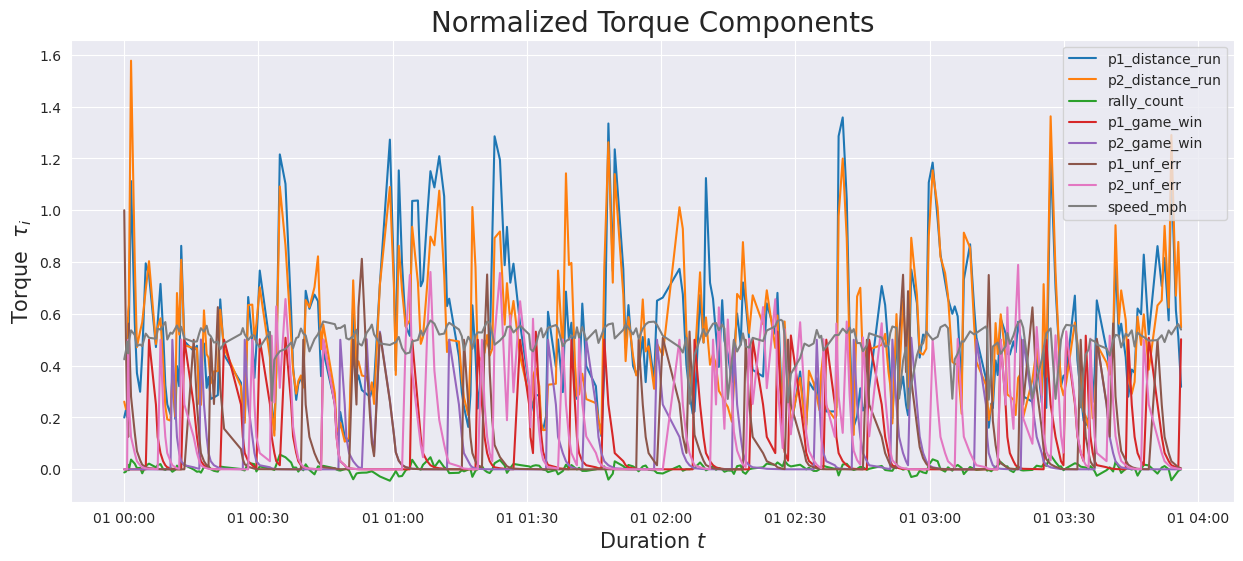

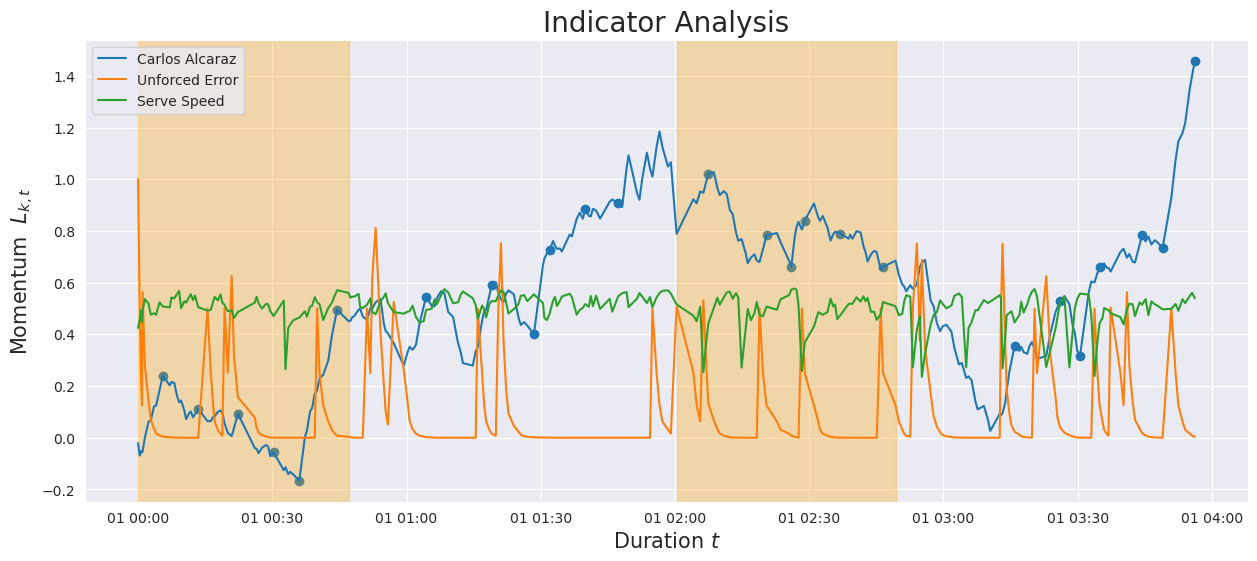

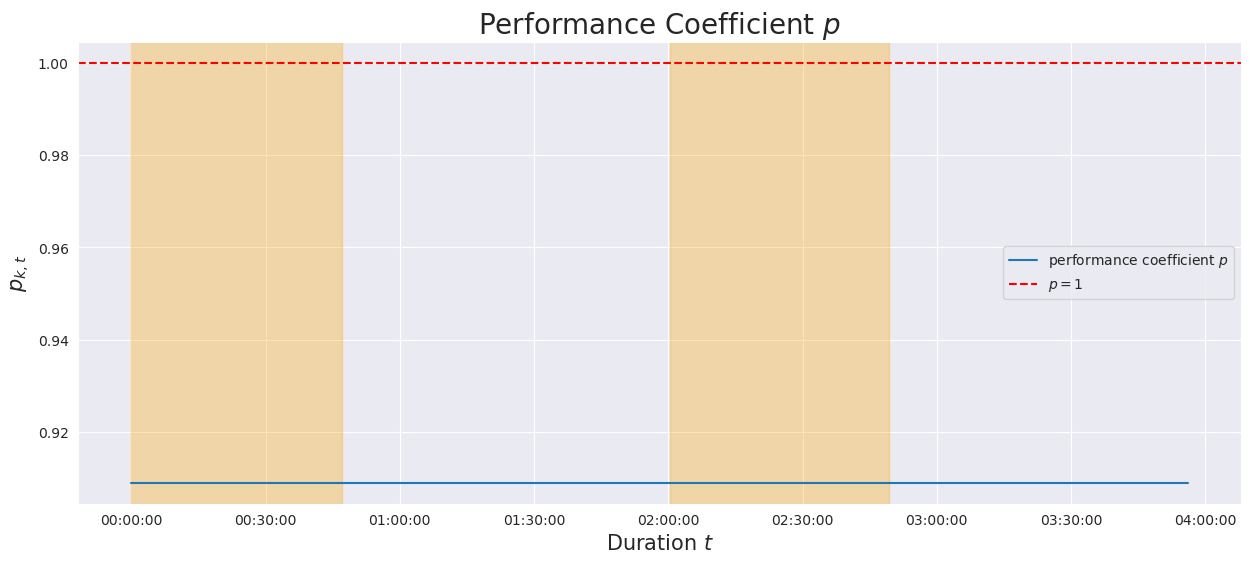

In [38]:
unit = tr.ModelUnit("Carlos Alcaraz", "Nicolas Jarry", data2)

unit.preprocess()
unit.prefilter()
#unit.show_components()

unit.calc_torque(players2["Inertia"])
unit.train(inputs, 0.75)
#u.show_params()
unit.construct_momentum()
unit.compare_indicator("speed_mph", "Serve Speed")
#u.compare_constructed()
vs.save(f"flow/6-1-Speed")
unit.construct_energy()
#unit.compare_performance()

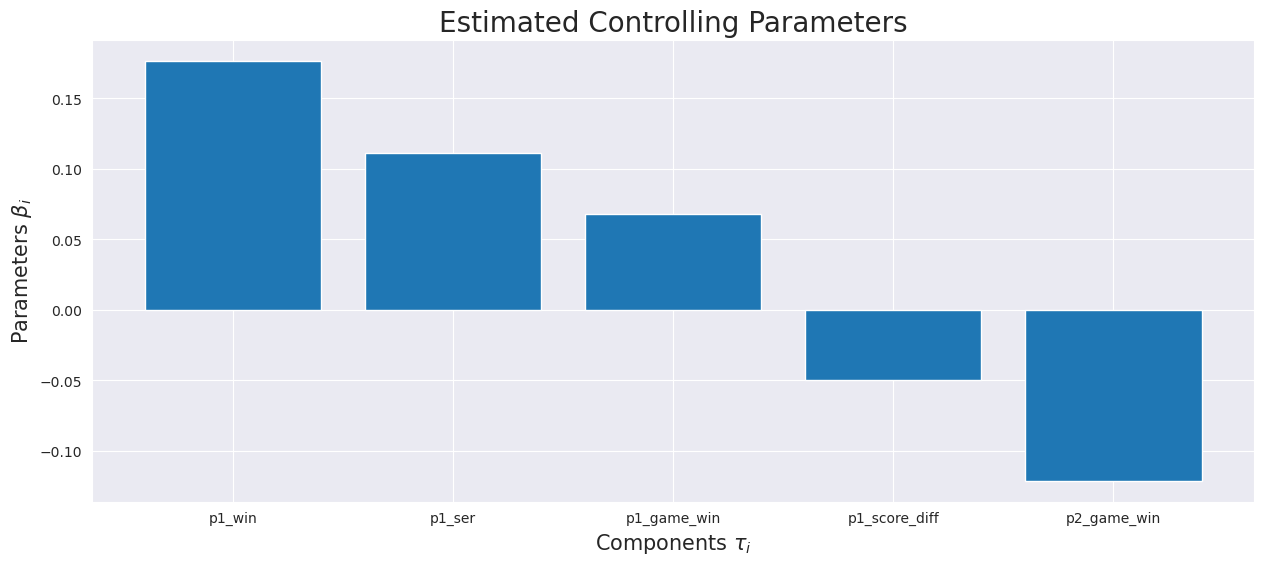

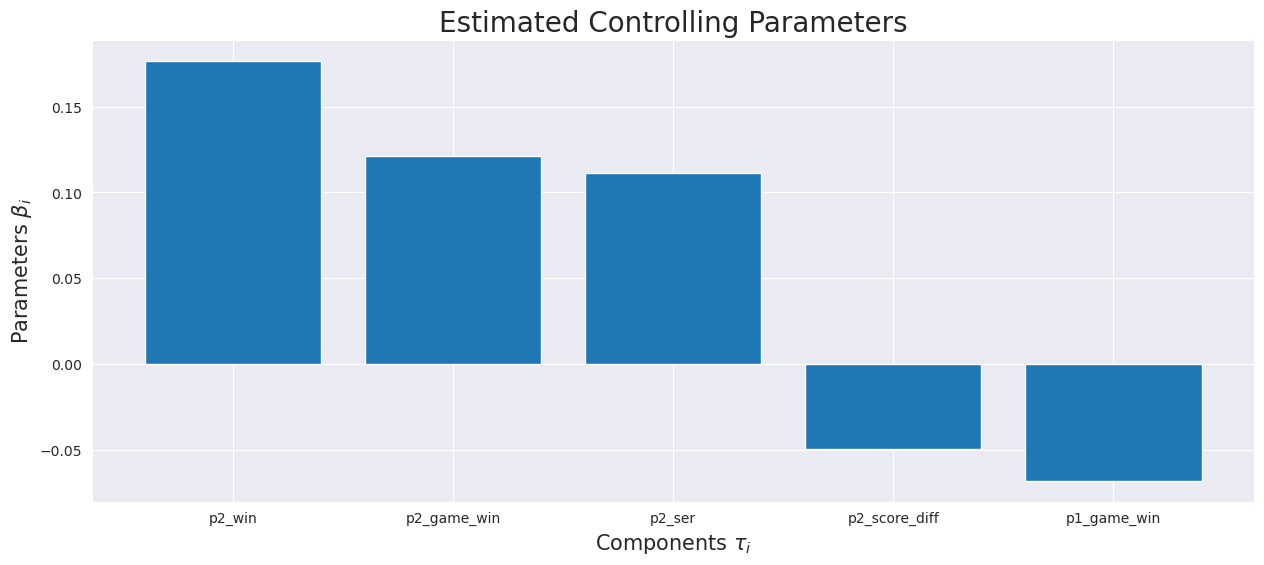

In [39]:
unit.show_params(True, 1)
unit.show_params(True, 2)